## TL streamfunction

In [1]:
import warnings

warnings.filterwarnings("ignore")  # noqa

In [2]:
# Data analysis and viz libraries
import aeolus.calc as acalc
import aeolus.coord as acoord
import aeolus.meta as ameta
import aeolus.plot as aplt
import iris
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib.offsetbox import AnchoredText
from windspharm.iris import VectorWind

In [3]:
# Local modules
import mypaths
from calc import (
    hdiv,
    integral,
    mass_weighted_vertical_integral,
    meridional_mean,
    moist_static_energy,
    spatial_mean,
    vert_mer_mean_of_mse_flux,
    wind_rot_div,
    zonal_mean,
)
from commons import MODELS
from grid import reverse_along_dim
from load_thai import LOAD_CONF
from names import names
from plot_func import (
    KW_AUX_TTL,
    KW_AXGR,
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    XLOCS,
    YLOCS,
    figsave,
    linspace_pm1,
)

In [4]:
plt.style.use("paper.mplstyle")


Bad key legend.labelcolor in file paper.mplstyle, line 10 ('legend.labelcolor : linecolor')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution


## Choose case

In [5]:
THAI_cases = ["Ben1"]

THAI_case = THAI_cases[0]

## Constants

Define atmospheric and planetary constants. Note the planet's radius is in meters!

In [6]:
if THAI_case.endswith("1"):
    import const_ben1_hab1 as const
else:
    import const_ben2_hab2 as const

## Loading the data

Load the time-averaged data previously preprocessed.

In [7]:
# Load data
datasets = {}  # Create an empty dictionary to store all data
# Loop over THAI cases (this loop can swapped places with the loop below if needed)
for THAI_case in THAI_cases:
    # for each of the THAI cases, create a nested directory for models
    datasets[THAI_case] = {}
    for model_key in MODELS.keys():
        datasets[THAI_case][model_key] = xr.open_dataset(
            mypaths.datadir / model_key / f"{THAI_case}_time_mean_{model_key}.nc"
        )
    datasets[THAI_case]["ExoCAM"][names.exocam.lev].attrs.update(units="hPa")
    datasets[THAI_case]["ROCKE3D"][names.rocke3d.pres].attrs.update(units="hPa")
    datasets[THAI_case]["ROCKE3D"][names.rocke3d.lev].attrs.update(positive="up", units="1")

Regrid to a common grid (otherwise `regrid_to_rotated_pole_coordinates()` returns huge numbers for the antistellar hemisphere).

In [8]:
new_lats = datasets[THAI_case]["UM"].latitude.values  # regrid to the UM grid
new_lons = datasets[THAI_case]["UM"].longitude.values
for THAI_case in THAI_cases:
    for model_key in MODELS.keys():
        model_names = names[model_key]
        if model_key == "UM":
            continue
        elif model_key == "LMDG":
            indexers = {model_names.y: slice(1, -1), model_names.x: slice(None, -1)}
        else:
            indexers = {model_names.y: slice(1, -1)}

        ds = datasets[THAI_case][model_key]
        new_ds = {}
        for d in ds.data_vars:
            vrbl = ds[d]
            if (model_names.y in vrbl.dims) and (model_names.x in vrbl.dims):
                # print(model_key, vrbl.name)
                vrbl = vrbl.isel(**indexers).interp(
                    coords={
                        model_names.y: new_lats,
                        model_names.x: new_lons,
                    },
                    kwargs={"fill_value": "extrapolate"},
                )
                new_ds[d] = vrbl
        datasets[THAI_case][model_key] = xr.Dataset(new_ds)

In [9]:
def add_coord_system(cube, model_key, radius):
    model_names = names[model_key]
    _coord_system = iris.coord_systems.GeogCS(semi_major_axis=radius, longitude_of_prime_meridian=0)
    for dim, standard_name in zip(["x", "y"], ["longitude", "latitude"]):
        dim_name = getattr(model_names, dim)
        try:
            cube.coord(dim_name).units = "degrees"
            cube.coord(dim_name).rename(standard_name)
            cube.coord(dim_name).coord_system = _coord_system
        except iris.exceptions.CoordinateNotFoundError:
            pass

In [10]:
def sf_const_factor(ds, model_key, const):
    """Combine constants for the mass streamfunction."""
    model_names = names[model_key]
    # Convert constants to iris cubes to preserve units
    RPLANET = iris.cube.Cube(const.rplanet_m, units="m")
    lat_cos_cube = np.cos(np.deg2rad(ds[model_names.y])).to_iris()
    lat_cos_cube.rename(model_names.y)
    if model_key == "LMDG":
        lat_cos_cube.coord("North latitude").rename(model_names.y)
    lat_cos_cube.units = "1"
    add_coord_system(lat_cos_cube, model_key, float(RPLANET.data))
    # Constant factor outside the integral
    return 2 * np.pi * RPLANET * lat_cos_cube

In [11]:
@ameta.update_metadata(name="tidally_locked_streamfunction", units="1e11 kg s-1")
def tl_streamfunction(ds, model_key, const, truncation=None):
    model_names = names[model_key]
    # Convert constants to iris cubes to preserve units
    RGAS = iris.cube.Cube(const.rgas, units="J kg-1 K-1")
    RPLANET = iris.cube.Cube(const.rplanet_m, units="m")
    GPLANET = iris.cube.Cube(const.gplanet, units="m s-2")
    # Convert data arrays to iris cubes
    u_cube = ds[model_names.u].to_iris()
    v_cube = ds[model_names.v].to_iris()
    temp_cube = ds[model_names.temp].to_iris()
    pres_cube = ds[model_names.pres].to_iris()
    pres_cube.convert_units("Pa")
    rho_cube = pres_cube / (RGAS * temp_cube)
    # Calculate divergent components of the wind
    vec = VectorWind(u_cube, v_cube, rsphere=float(RPLANET.data))
    u_cube, v_cube = vec.irrotationalcomponent(truncation=truncation)
    # Make the lon/lat coordinates CF-compliant
    for cube in [u_cube, v_cube, rho_cube]:
        if model_key == "LMDG":
            try:
                cube.coord("North latitude").rename(model_names.y)
                cube.coord("East longitude").rename(model_names.x)
            except iris.exceptions.CoordinateNotFoundError:
                pass
        add_coord_system(cube, model_key, float(RPLANET.data))
    # Transform to tidally-locked coordinates
    _, v_tl_cube = acalc.rotate_winds_to_tidally_locked_coordinates(u_cube, v_cube)
    v_tl_cube = acalc.regrid_to_tidally_locked_coordinates(v_tl_cube)
    v_tl_zm = acalc.zonal_mean(v_tl_cube)
    rho_tl_zm = acalc.zonal_mean(acalc.regrid_to_tidally_locked_coordinates(rho_cube))
    # Calculate the integral
    if model_key == "ExoCAM":
        # alt_cube = ds[model_names.z].to_iris()
        # add_coord_system(alt_cube, model_key, float(rplanet.data))
        # alt_tl_zm = acalc.zonal_mean(acalc.regrid_to_tidally_locked_coordinates(alt_cube))
        # dzdp = acalc.deriv(alt_tl_zm, "atmosphere_hybrid_sigma_pressure_coordinate")
        sf_tl = -1 * acalc.cumsum(v_tl_zm, "z", True) / GPLANET
    elif model_key == "LMDG":
        sf_tl = acalc.cumsum(v_tl_zm * rho_tl_zm, "z", True)
    elif model_key == "ROCKE3D":
        # ysub = slice(None, None)
        alt_cube = ds[model_names.z].to_iris()
        add_coord_system(alt_cube, model_key, float(RPLANET.data))
        alt_tl_zm = acalc.zonal_mean(acalc.regrid_to_tidally_locked_coordinates(alt_cube))
        dzdp = acalc.deriv(alt_tl_zm, model_names.lev)
        sf_tl = acalc.cumsum(v_tl_zm * rho_tl_zm * dzdp, "z", True)
    elif model_key == "UM":
        sf_tl = acalc.cumsum(v_tl_zm * rho_tl_zm, "z", True)
    sf_tl *= sf_const_factor(ds, model_key, const)
    return sf_tl

In [12]:
VRBLS = {}
for THAI_case in THAI_cases:
    VRBLS[THAI_case] = {}
    for model_key in LOAD_CONF.keys():
        model_names = names[model_key]
        VRBLS[THAI_case][model_key] = {}
        VRBLS[THAI_case][model_key]["sf_tl"] = tl_streamfunction(
            datasets[THAI_case][model_key], model_key, const=const
        )
        _pres = datasets[THAI_case][model_key][model_names.pres].to_iris()
        _pres.convert_units("hPa")
        if model_key == "LMDG":
            _pres.coord("North latitude").rename(model_names.y)
            _pres.coord("East longitude").rename(model_names.x)
        add_coord_system(_pres, model_key, const.rplanet_m)
        VRBLS[THAI_case][model_key]["mean_pres"] = acalc.spatial_mean(_pres)

In [13]:
kw_plt = dict(levels=linspace_pm1(6) * 6, cmap="PuOr_r", extend="both")

In [14]:
tl_ticks = np.arange(-90, 91, 30)
tl_ticklabels = [f"{i}" for i in tl_ticks]
tl_ticklabels[0] += "\nAS"
tl_ticklabels[-1] += "\nSS"
tl_ticklabels[tl_ticklabels.index("0")] += "\nT"

Saved to ../plots/Ben1__tl_sf.png


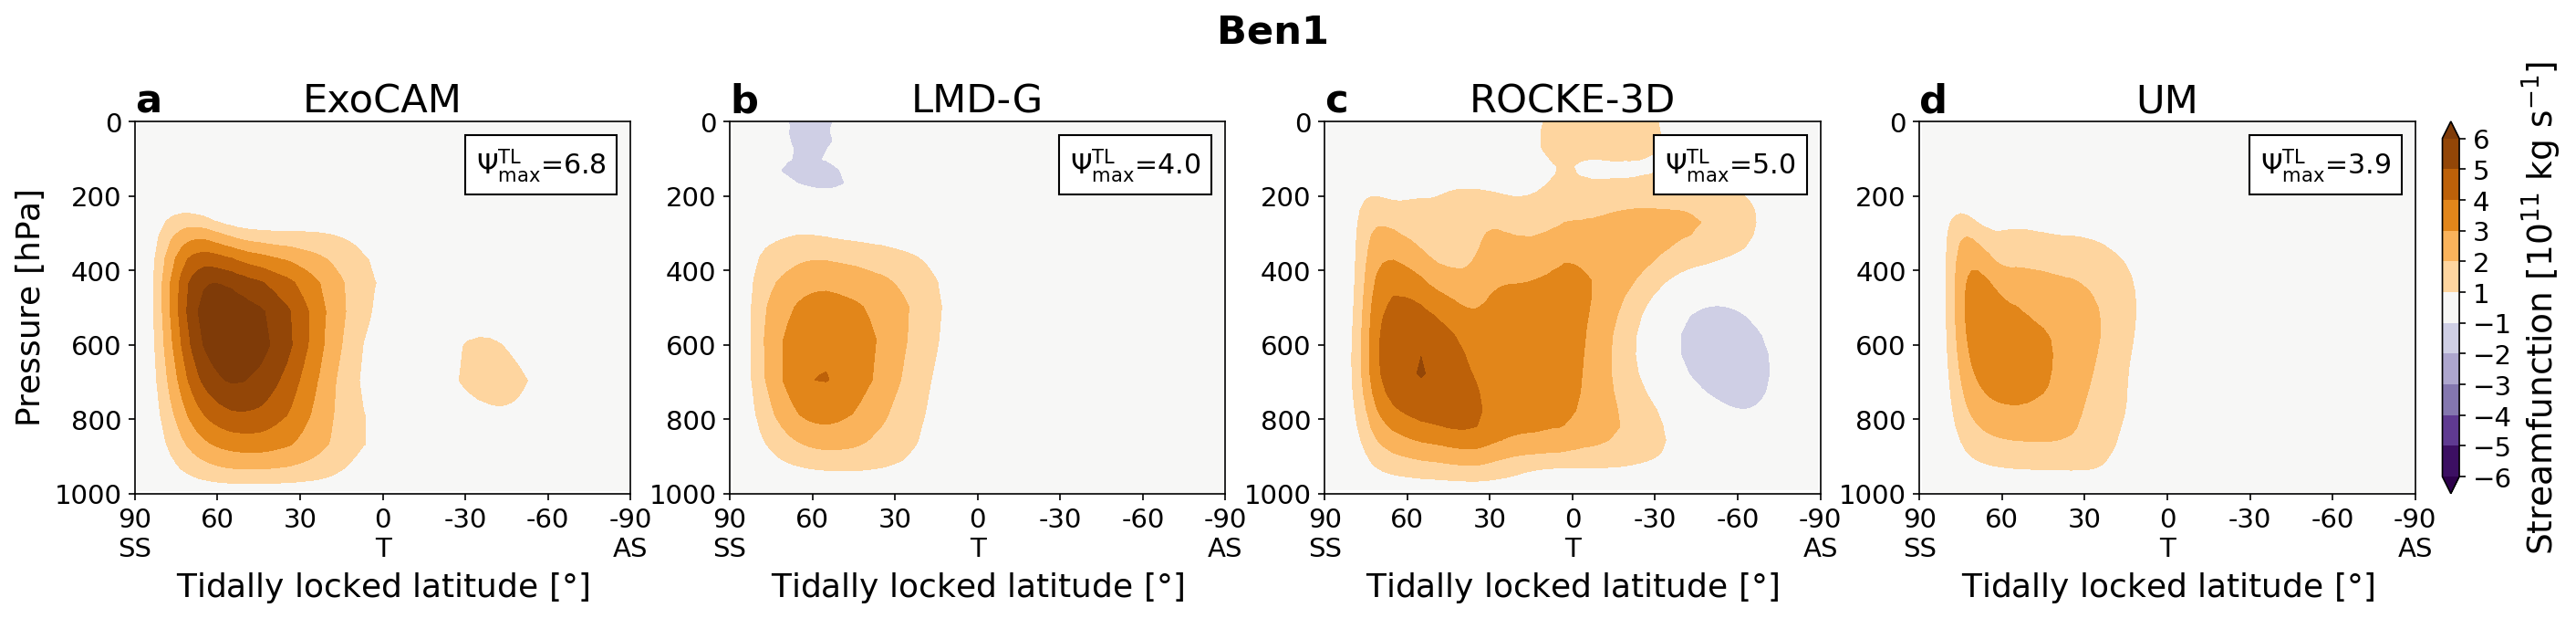

In [15]:
ncols = 4
nrows = 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6.4 * ncols, 3.6 * nrows), squeeze=False)

iletters = aplt.subplot_label_generator()
for (model_key, model_dict), ax in zip(MODELS.items(), axs.flat):
    model_names = names[model_key]
    cube = VRBLS[THAI_case][model_key]["sf_tl"]
    ypoints = cube.coord(model_names.y).points
    zpoints = VRBLS[THAI_case][model_key]["mean_pres"].data
    arr = cube.data
    cntrf = ax.contourf(ypoints, zpoints, arr, **kw_plt)
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
    ax.set_title(model_dict["title"], **KW_MAIN_TTL)
    ax.set_ylim(1000, 0)
    ax.set_xlim(-90, 90)
    ax.set_xticks(tl_ticks)
    ax.set_xticklabels(tl_ticklabels)
    ax.invert_xaxis()  # so that clockwise is positive
    if ax.is_first_col():
        ax.set_ylabel("Pressure [$hPa$]", fontsize="x-large")
    if ax.is_last_row():
        ax.set_xlabel("Tidally locked latitude [$\degree$]", fontsize="x-large")
    # ax.set_yscale("symlog")

    ax.add_artist(
        AnchoredText(
            f"$\Psi^{{TL}}_{{max}}$={float(arr.max()):.1f}",
            loc="upper right",
            prop=dict(size="large"),
        )
    )
cbar = fig.colorbar(cntrf, ax=axs, pad=0.01, orientation="vertical", aspect=20)
cbar.ax.set_ylabel("Streamfunction [$10^{11}$ $kg$ $s^{-1}$]")
cbar.set_ticks(linspace_pm1(6) * 6)
fig.suptitle(f"{THAI_case}", fontsize="xx-large", fontweight="bold", x=0.45, y=1.1)
figsave(fig, mypaths.plotdir / f"{THAI_case}__tl_sf")

In [ ]:
# lons = v_tl_cube.coord(model_names.x).points
# lats = v_tl_cube.coord(model_names.y).points
# lons2d, lats2d = np.meshgrid(lons, lats)
# skip = slice(None, None, 1), slice(None, None, 1)

# iz = 35
# plt.subplot(211)
# plt.title(u_cube.coord("level").points[iz])
# plt.contourf(
#     lons,
#     lats,
#     (u_cube.data[iz, ...][ysub, :] ** 2 + v_cube.data[iz, ...][ysub, :] ** 2) ** 0.5,
# )
# plt.colorbar()
# plt.quiver(
#     lons2d[skip],
#     lats2d[skip],
#     u_cube.data[iz, ...][ysub, :][skip],
#     v_cube.data[iz, ...][ysub, :][skip],
# )

# plt.subplot(212)
# plt.contourf(
#     lons, lats, (u_tl_cube.data[iz, ...] ** 2 + v_tl_cube.data[iz, ...] ** 2) ** 0.5
# )
# plt.colorbar()
# plt.quiver(
#     lons2d[skip],
#     lats2d[skip],
#     u_tl_cube.data[iz, ...][skip],
#     v_tl_cube.data[iz, ...][skip],
# )

In [ ]:
# # Load data
# datasets = {}  # Create an empty dictionary to store all data
# # Loop over THAI cases (this loop can swapped places with the loop below if needed)
# for THAI_case in [THAI_case]:
#     # for each of the THAI cases, create a nested directory for models
#     datasets[THAI_case] = {}
#     for model_key in MODELS.keys():
#         model_names = names[model_key]
#         ds = xr.open_dataset(mypaths.datadir / model_key / f"{THAI_case}_time_mean_{model_key}.nc")
#         if model_key in ["ExoCAM", "LMDG", "ROCKE3D"]:
#             # Regrid ExoCAM, LMD-G and ROCKE-3D data to be compatible with `windspharm`:
#             # if latitudes are equally-spaced and even-numbered, they should not include poles.
#             nlat = 50  # new number of latitudes: 50
#             delta_lat = 180 / nlat
#             new_lats = np.linspace(90 - 0.5 * delta_lat, -90 + 0.5 * delta_lat, nlat)
#         else:
#             new_lats = None
#         if model_key in ["ExoCAM", "LMDG"]:
#             lon_slice = slice(None, -1)  # omit the 180E longitude which is repeated
#         else:
#             lon_slice = slice(None, None)
#         ds_regr = {}
#         for d in ds.data_vars:
#             vrbl = ds[d]
#             if model_names.x in ds[d].dims:
#                 vrbl = vrbl.isel(**{model_names.x: lon_slice})
#             if (model_names.y in ds[d].dims) and (new_lats is not None):
#                 vrbl = vrbl.isel(**{model_names.y: slice(1, -1)}).interp(
#                     **{
#                         model_names.y: new_lats,
#                         "kwargs": {"fill_value": "extrapolate"},
#                     },
#                 )
#             ds_regr[d] = vrbl
#         datasets[THAI_case][model_key] = xr.Dataset(ds_regr)
#         del ds
#     datasets[THAI_case]["ExoCAM"][names.exocam.lev].attrs.update(units="hPa")
#     datasets[THAI_case]["ROCKE3D"][names.rocke3d.pres].attrs.update(units="hPa")
#     datasets[THAI_case]["ROCKE3D"][names.rocke3d.lev].attrs.update(positive="up", units="1")